Celem projektu jest analiza danych pochodzących ze strony Boxrec.com która jest czołowym portalem rankingowym dla boksu zawodowego. analizując dane będe starać sie przewidziec jaką ilość punktów mogą osiągnąć zawodnicy na podstawie danych dostepnych w rankingu. 
Dane zostały pobrane i wstepnie przygotowane za pomocą kodu napisanego przeze mnie w jezuku R. 
Proces pobierania danych ze strony dzieli sie na trzy etapy ponieważ informacje były rozsiane w różnych miejscach w strukturze portalu.

W pierwszym kroku pobieram obszar z danymi i zapisuje je w formie tabeli ktorą nastepnie transponuje do wiersza.
Kod napisany jest w taki sposob ze pętla przechodzi przez kolejne profile dodając kolejne wiersze do dataframeu.
Inna pętla pobiera w podobny sposob dane o ilosci wygranych , przegranych walk oraz ilosci walk wygranych i przegranych przez KO. 

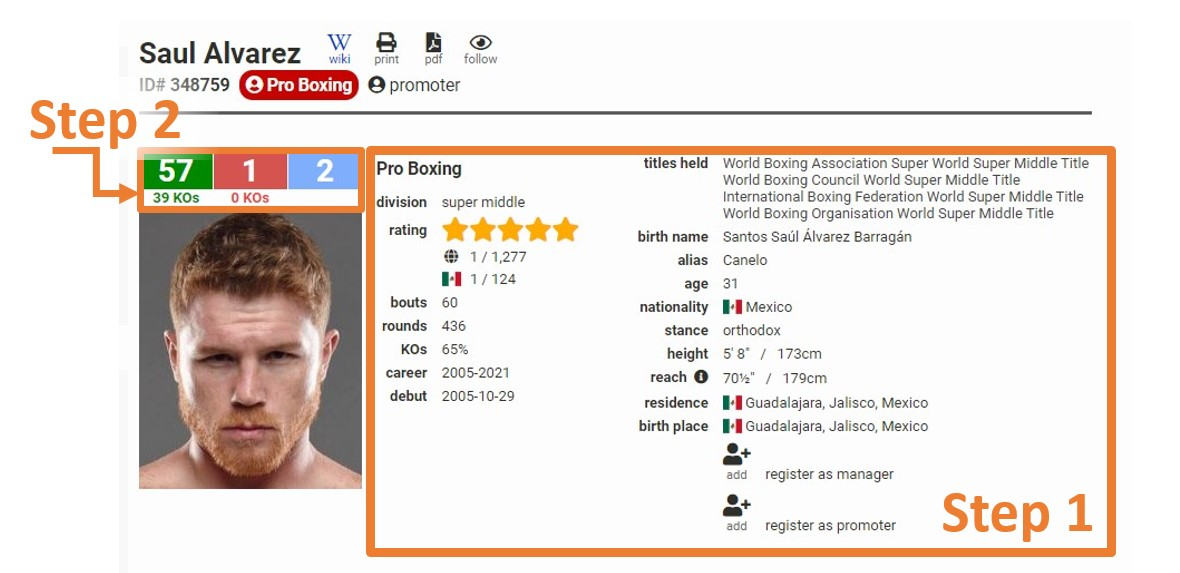

Trzecia petla w kodzie pobiera dane ze strony głownej gdzie dostepne są dane z punktami w rankingu ogólnym oraz "kolorowe kwadraciki". W tych kolorowych kwadracikach zapisana jest informacja o ostatnich sześciu stoczonych walkach. 
Sąt to bardzo istotne informacje ponieważ głowny scoring posłuży mi za Y natiomiast z ostatnich 6 walk stworze dodatkowy rating- moim zdaniuem pomocny z punktu widzenia przedykcji ratingu - Ale! Przekonamy się! 

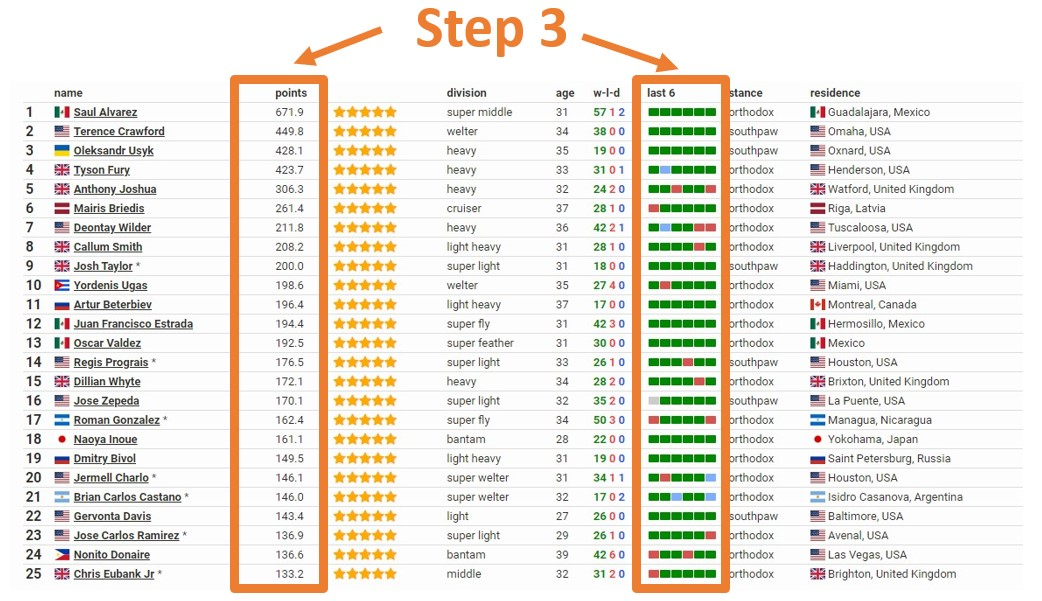

Psiadając zebrane dane w formie trzech osobnych dataframeów łącze je i czyszę do przystępnej postaci. Mając tak spreparowane dane przechodzę do Jupiternotebooka gdzie bede przeprowadzał przygotowanie danych, ich analizę oraz próbę stworzenia modelu przewidującego punktację rankingową. 

In [233]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

In [234]:
# Wczytuję dane wcześniej przygotowane przy pomocy kodu w R
br_active= pd.read_csv('active boxers/results_grandtotal_active.csv')
br_active.head()

C:\Users\Karol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,boxerID,wins,defeats,draws,wins_by_KO,defeats_by_KO,Pro.Boxing,division,rating_word,rating_native,...,promoter,MMA,boxer,points,last1,last2,last3,last4,last5,last6
0,5745,97,5,0,62 KOs,2 KOs,Pro Boxing,light heavy,"154 / 1,053",2 / 13,...,NaN,NaN,Sirimongkhon Iamthuam,0.481,L,W,L,W,W,L
1,6283,10,35,2,3 KOs,11 KOs,Pro Boxing,fly,470 / 565,135 / 154,...,NaN,NaN,Jesus Jimenez Ruiz,0.001,L,L,L,L,L,L
2,6522,54,30,0,41 KOs,16 KOs,Pro Boxing,heavy,"274 / 1,222",21 / 46,...,NaN,NaN,Danny Williams\r\n *,0.105,W,L,L,W,L,L
3,7126,5,24,0,4 KOs,19 KOs,Pro Boxing,super welter,"1,434 / 1,756",195 / 246,...,NaN,NaN,Jesus Arce Sarmiento,0.000,L,L,L,L,L,L
4,7345,5,42,0,4 KOs,30 KOs,Pro Boxing,light heavy,"643 / 1,053",11 / 18,...,NaN,NaN,Miguel Angel Suarez,0.002,L,L,L,L,L,L


In [235]:
#czyszczenie danych
# usuwam kolumny które nie maja znaczących informacji
br_active_cleaned= br_active.drop(columns=['KOs','rounds'])
# rozdzielam kolumny ktore mają zduplikowane przedzielone separatorem 
br_active_cleaned[['height inch', 'height cm']]= br_active_cleaned['height'].str.split(' / ', 1, expand=True)
br_active_cleaned[['reach inch', 'reach cm']]= br_active_cleaned['reach'].str.split(' / ', 1, expand=True)
br_active_cleaned[['rating_world_position', 'rating_world_category']]= br_active_cleaned['rating_word'].str.split(' / ', 1, expand=True).replace(',','', regex=True)
br_active_cleaned[['rating_native_position', 'rating_native_category']]= br_active_cleaned['rating_native'].str.split(' / ', 1, expand=True).replace(',','', regex=True)
br_active_cleaned[['career start', 'career edge']]= br_active_cleaned['career'].str.split('-', 1, expand=True)
# sprowadzam dane do postaci numerycznej
br_active_cleaned['reach cm']= br_active_cleaned['reach cm'].str.extract(r'([0-9]+)')
br_active_cleaned['height cm']= br_active_cleaned['height cm'].str.extract(r'([0-9]+)')
br_active_cleaned['wins_by_KO']= br_active_cleaned['wins_by_KO'].str.extract(r'([0-9]+)')
br_active_cleaned['defeats_by_KO']= br_active_cleaned['defeats_by_KO'].str.extract(r'([0-9]+)')

# definiuję typy danych
br_active_cleaned = br_active_cleaned.astype({'rating_world_position':'float',
                                              'rating_native_position':'float',
                                              'reach cm':'float',
                                              'height cm':'float',
                                              'wins':'float',
                                              'defeats':'float',
                                              'draws':'float',
                                              'bouts':'float',
                                              'wins_by_KO':'float',
                                              'defeats_by_KO':'float',
                                              'age':'float',
                                              'points':'float'})

In [236]:
# obliczam tzw KO ratio dla poszczególnych pięściarzy
br_active_cleaned['KOWratio'] = (br_active_cleaned['wins_by_KO']/br_active_cleaned['bouts']).round(4).fillna(0)
br_active_cleaned['KOWPratio'] = (br_active_cleaned['wins_by_KO']/br_active_cleaned['wins']).round(4).fillna(0)
br_active_cleaned['KODratio'] = (br_active_cleaned['defeats_by_KO']/br_active_cleaned['bouts']).round(4).fillna(0)
br_active_cleaned['KODPratio'] = (br_active_cleaned['defeats_by_KO']/br_active_cleaned['defeats']).round(4).fillna(0)


In [237]:
# Kolumny last1', 'last2','last3', 'last4', 'last5', 'last6' zawierają werdykt ostatnich 6 walk danego zawodnika. 
# W - win, L- loss, D- draw, NC- no contest, B- blank 
# zamieniam oznaczenia alfabetyczne na liczbowe nadając im odpowiednie wagi. 
# W myśl twierdzenia "zawodnik jest tak dobry jak jego 3 ostatnie walki" ostatnia stoczona walka ma najwyższą wage 
# następnie z każda kolejna walka wstecz ma mniejszą wartość 

def lastone (i):
    if (i=="W"):
        return 6
    elif (i=="D"):
        return 5
    elif (i=="L"):
        return 3
    elif (i=='NC'):
        return 1
    elif (i=='B'):
        return 0
    else:
        return "nan"

def lasttwo (i):
    if (i=="W"):
        return 5
    elif (i=="D"):
        return 4
    elif (i=="L"):
        return 2
    elif (i=='NC'):
        return 1
    elif (i=='B'):
        return 0
    else:
        return "nan"    

def lastthree (i):
    if (i=="W"):
        return 4
    elif (i=="D"):
        return 3
    elif (i=="L"):
        return 1
    elif (i=='NC'):
        return 0
    elif (i=='B'):
        return 0
    else:
        return "nan"    
    
def lastfour (i):
    if (i=="W"):
        return 3
    elif (i=="D"):
        return 2
    elif (i=="L"):
        return 0
    elif (i=='NC'):
        return 0
    elif (i=='B'):
        return 0
    else:
        return "nan"    

br_active_cleaned['last6V']= [lastone(i) for i in br_active_cleaned[['last6']].values]     
br_active_cleaned['last5V']= [lasttwo(i) for i in br_active_cleaned[['last5']].values]  
br_active_cleaned['last4V']= [lastthree(i) for i in br_active_cleaned[['last4']].values] 
br_active_cleaned['last3V']= [lastfour(i) for i in br_active_cleaned[['last3']].values] 
br_active_cleaned['last2V']= [lastfour(i) for i in br_active_cleaned[['last2']].values]
br_active_cleaned['last1V']= [lastfour(i) for i in br_active_cleaned[['last1']].values] 

# sumuję wszystkie kolumny tworząc score ostatnich 6 walk
br_active_cleaned['last6Fwec']= br_active_cleaned['last1V']+br_active_cleaned['last2V']+br_active_cleaned['last3V']+br_active_cleaned['last4V']+br_active_cleaned['last5V']+br_active_cleaned['last6V']

# obliczam czas trwania kariery w dniach
# br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['career start'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days
br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['debut'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days

In [238]:
# obliczam czas trwania kariery w dniach
br_active_cleaned['debut'] = pd.to_datetime(br_active_cleaned['debut'])
# br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['career start'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days
br_active_cleaned['career_period'] = (pd.to_datetime(br_active_cleaned['debut'])-pd.to_datetime(br_active_cleaned['career edge'])).abs().dt.days

In [239]:
# oznaczam zawodników z backgroundem MMA 
br_active_cleaned_mmaf = br_active_cleaned.dropna(subset=['MMA'])
br_active_cleaned_mman = br_active_cleaned[br_active_cleaned['MMA'].isnull()]
br_active_cleaned_mman=br_active_cleaned_mman.assign(MMA='N')
br_active_cleaned_mmaf=br_active_cleaned_mmaf.assign(MMA='Y')
br_active_cleaned= pd.concat([br_active_cleaned_mmaf,br_active_cleaned_mman], axis=0)

In [240]:
br_active_cleaned.columns

Index(['boxerID', 'wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO',
       'Pro.Boxing', 'division', 'rating_word', 'rating_native', 'bouts',
       'career', 'debut', 'titles.held', 'birth.name', 'alias', 'age',
       'nationality', 'stance', 'height', 'reach', 'residence', 'birth.place',
       'manager.agent', 'promoter', 'MMA', 'boxer', 'points', 'last1', 'last2',
       'last3', 'last4', 'last5', 'last6', 'height inch', 'height cm',
       'reach inch', 'reach cm', 'rating_world_position',
       'rating_world_category', 'rating_native_position',
       'rating_native_category', 'career start', 'career edge', 'KOWratio',
       'KOWPratio', 'KODratio', 'KODPratio', 'last6V', 'last5V', 'last4V',
       'last3V', 'last2V', 'last1V', 'last6Fwec', 'career_period'],
      dtype='object')

In [241]:
# Tworzę tabelę do analizy 
# wybieram kolumny z ktorych bede chcial skorzystać
work_atributes = ['boxerID','age','wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO',
 'division', 'bouts','debut','career edge','career_period',
 'nationality', 'stance', 'MMA', 'boxer','height cm','reach cm',
 'points','rating_world_position','rating_world_category', 'rating_native_position','rating_native_category',
 'last1', 'last2','last3', 'last4', 'last5', 'last6','titles.held',
 'KOWratio','KOWPratio','KODratio','KODPratio','last6Fwec']

# Tworzę nowy DF do analizy
br_active_work= br_active_cleaned.loc[:,work_atributes]

br_active_work.head()

,boxerID,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,division,bouts,debut,...,last3,last4,last5,last6,titles.held,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
37,19280,44.0,6.0,34.0,1.0,5.0,29.0,super welter,41.0,1998-02-08,...,L,L,L,L,NaN,0.1220,0.8333,0.7073,0.8529,6
379,291908,37.0,34.0,2.0,2.0,25.0,1.0,super middle,38.0,2005-01-27,...,W,L,D,W,NaN,0.6579,0.7353,0.0263,0.5000,20
2450,609451,39.0,1.0,15.0,1.0,1.0,6.0,middle,17.0,2012-04-12,...,L,L,L,L,NaN,0.0588,1.0000,0.3529,0.4000,6
2632,623357,33.0,14.0,19.0,3.0,8.0,8.0,super light,38.0,2012-09-15,...,L,D,W,L,NaN,0.2105,0.5714,0.2105,0.4211,11
2714,628451,30.0,23.0,3.0,1.0,12.0,0.0,super feather,27.0,2012-10-06,...,L,W,L,L,NaN,0.4444,0.5217,0.0000,0.0000,15


In [242]:
# Sprawdzam gdzie nie ma danych
braw = br_active_work.copy()
braw.isna().sum().sort_values(ascending=True)

boxerID                       0
KODratio                      0
KOWPratio                     0
KOWratio                      0
last6                         0
last5                         0
last4                         0
last3                         0
last2                         0
last1                         0
points                        0
KODPratio                     0
boxer                         0
MMA                           0
last6Fwec                     0
bouts                         0
wins                          0
career_period                 0
career edge                   0
defeats                       0
draws                         0
debut                         0
wins_by_KO                    0
defeats_by_KO                 0
rating_world_position       374
rating_world_category       374
division                    374
nationality                 715
rating_native_category     1026
rating_native_position     1026
age                        1917
stance  

In [243]:
no_rows = braw.shape[0]
(braw.isnull().sum()/no_rows).sort_values(ascending=True)

boxerID                   0.000000
KODratio                  0.000000
KOWPratio                 0.000000
KOWratio                  0.000000
last6                     0.000000
last5                     0.000000
last4                     0.000000
last3                     0.000000
last2                     0.000000
last1                     0.000000
points                    0.000000
KODPratio                 0.000000
boxer                     0.000000
MMA                       0.000000
last6Fwec                 0.000000
bouts                     0.000000
wins                      0.000000
career_period             0.000000
career edge               0.000000
defeats                   0.000000
draws                     0.000000
debut                     0.000000
wins_by_KO                0.000000
defeats_by_KO             0.000000
rating_world_position     0.018653
rating_world_category     0.018653
division                  0.018653
nationality               0.035661
rating_native_catego

In [244]:
# wyrzucam kolumny z najwiekszymi brakami danych
braw= braw.drop(columns= ['titles.held','reach cm','height cm','stance'])
# wyrzucam braki w danych 
braw= braw.dropna()
braw.shape

(17490, 31)

In [245]:
# sprawdzam podsrawowe miary statystyczne danych
braw.describe().round(2)

,boxerID,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,bouts,career_period,points,rating_world_position,rating_native_position,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
count,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00,17490.00
mean,817282.31,27.72,6.36,4.18,0.44,3.55,2.02,11.03,1442.24,1.36,666.52,53.27,0.31,0.42,0.22,0.35,12.51
std,197815.56,6.07,8.00,7.92,0.89,5.21,4.11,12.95,1613.40,11.40,465.50,73.01,0.31,0.37,0.32,0.40,6.70
min,5745.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,720109.25,23.00,1.00,0.00,0.00,0.00,0.00,2.00,274.00,0.00,276.00,6.00,0.00,0.00,0.00,0.00,6.00
50%,850765.00,27.00,3.00,1.00,0.00,1.00,1.00,6.00,825.00,0.01,592.00,20.00,0.24,0.44,0.05,0.20,12.00
75%,991872.00,31.00,9.00,5.00,1.00,5.00,2.00,15.00,2085.00,0.19,986.00,68.00,0.50,0.73,0.33,0.70,18.00
max,1061024.00,59.00,97.00,221.00,12.00,62.00,66.00,248.00,11669.00,680.70,1947.00,381.00,1.00,1.00,1.00,1.00,24.00


In [246]:
#usuwam dane powyżej 99 percentylu
braw[braw.age < np.percentile(braw.age,99)]
braw[braw.wins < np.percentile(braw.wins,99)]
braw[braw.defeats < np.percentile(braw.defeats,99)]
braw[braw.draws < np.percentile(braw.draws,99)]
braw[braw.wins_by_KO < np.percentile(braw.wins_by_KO,99)]
braw[braw.defeats_by_KO < np.percentile(braw.defeats_by_KO,99)]
braw[braw.bouts < np.percentile(braw.bouts,99)]
braw[braw.points < np.percentile(braw.points,99)]
braw[braw.rating_world_position < np.percentile(braw.rating_world_position,99)]
braw[braw.rating_native_position < np.percentile(braw.rating_native_position,99)]
braw[braw.KODPratio < np.percentile(braw.KODPratio,99)]
braw[braw.KOWPratio < np.percentile(braw.KODPratio,99)]
braw[braw.KOWratio < np.percentile(braw.KODPratio,99)]
braw[braw.KODratio < np.percentile(braw.KODPratio,99)]
braw[braw.last6Fwec < np.percentile(braw.last6Fwec,99)]

,boxerID,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,division,bouts,debut,...,last2,last3,last4,last5,last6,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
37,19280,44.0,6.0,34.0,1.0,5.0,29.0,super welter,41.0,1998-02-08,...,L,L,L,L,L,0.1220,0.8333,0.7073,0.8529,6
379,291908,37.0,34.0,2.0,2.0,25.0,1.0,super middle,38.0,2005-01-27,...,W,W,L,D,W,0.6579,0.7353,0.0263,0.5000,20
2450,609451,39.0,1.0,15.0,1.0,1.0,6.0,middle,17.0,2012-04-12,...,L,L,L,L,L,0.0588,1.0000,0.3529,0.4000,6
2632,623357,33.0,14.0,19.0,3.0,8.0,8.0,super light,38.0,2012-09-15,...,L,L,D,W,L,0.2105,0.5714,0.2105,0.4211,11
2714,628451,30.0,23.0,3.0,1.0,12.0,0.0,super feather,27.0,2012-10-06,...,W,L,W,L,L,0.4444,0.5217,0.0000,0.0000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20042,1060736,24.0,0.0,1.0,0.0,0.0,1.0,cruiser,1.0,2022-01-08,...,B,B,B,B,L,0.0000,0.0000,1.0000,1.0000,3
20044,1061012,23.0,0.0,1.0,0.0,0.0,1.0,light heavy,1.0,2021-12-11,...,B,B,B,B,L,0.0000,0.0000,1.0000,1.0000,3
20045,1061017,26.0,0.0,1.0,0.0,0.0,0.0,cruiser,1.0,2022-01-09,...,B,B,B,B,L,0.0000,0.0000,0.0000,0.0000,3
20048,1061023,27.0,1.0,0.0,0.0,1.0,0.0,super bantam,1.0,2021-12-25,...,B,B,B,B,W,1.0000,1.0000,0.0000,0.0000,6


In [247]:
braw["points"] = braw["points"].replace(-np.inf,0)
print(braw['points'])

37        0.000
379      19.540
2450      0.002
2632      0.097
2714     12.590
          ...  
20042     0.000
20044     0.000
20045     0.000
20048     0.003
20049     0.000
Name: points, Length: 17490, dtype: float64


<AxesSubplot:xlabel='points', ylabel='rating_world_position'>

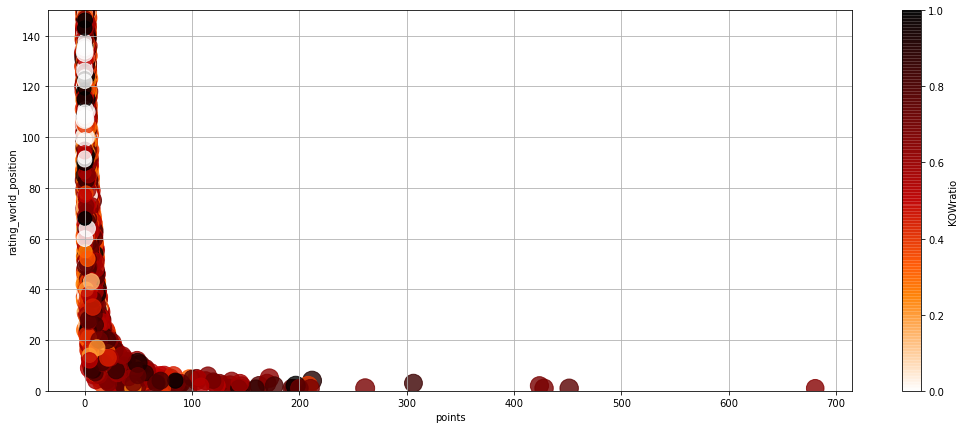

In [248]:
braw.plot(kind="scatter", x="points", y="rating_world_position", alpha=0.8, figsize=(18,7),ylim=(0,150),
        c="KOWratio",s=[n*10 for n in braw["age"]], cmap="gist_heat_r",grid=True, colorbar=True, sharex=False)

<AxesSubplot:xlabel='points', ylabel='wins'>

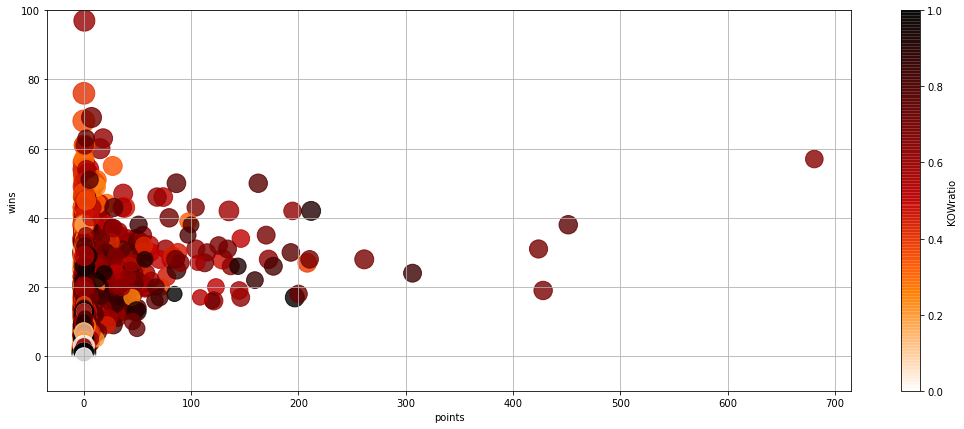

In [249]:
braw.plot(kind="scatter", x="points", y="wins", alpha=0.8, figsize=(18,7),ylim=(-10,100),
        c="KOWratio",s=[n*10 for n in braw["age"]], cmap="gist_heat_r",grid=True, colorbar=True, sharex=False)

<AxesSubplot:title={'center':'Division '}, ylabel='division'>

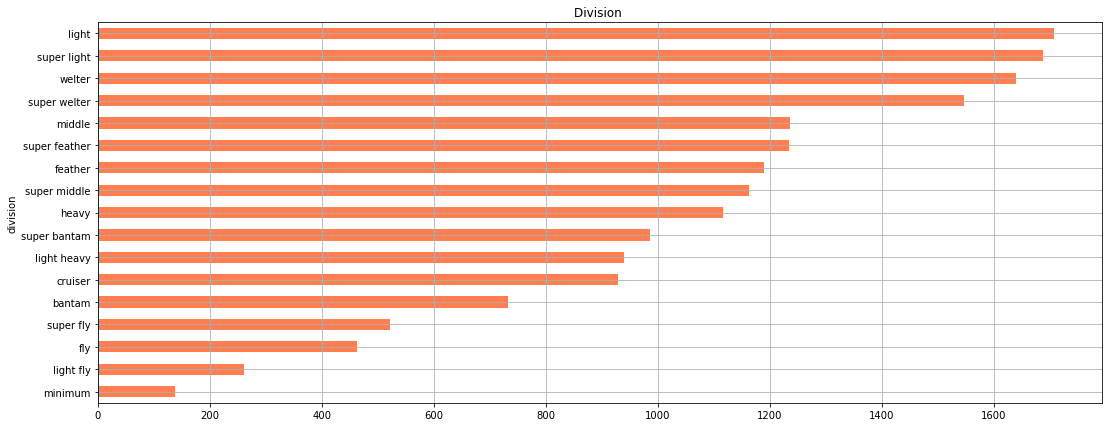

In [250]:
# Sprawdzam w ktorej kategorii jest najwięcej zawodników
divplot=braw.loc[:,['boxerID','division']].groupby(['division']).count().reset_index().sort_values(by=['boxerID'], ascending=True)
divplot.plot(kind='barh', x='division', y='boxerID',  figsize=(18,7), legend=False, grid=True, color='coral', title='Division ')
# sns.countplot(x="division", data = braw, hue='division', palette="muted")

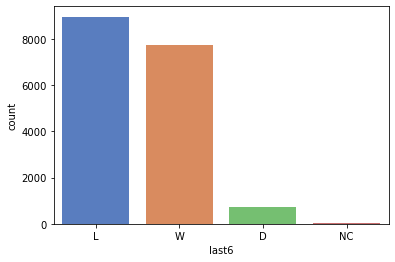

In [251]:
sns.countplot(x="last6", data = braw, palette="muted")
plt.show()

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

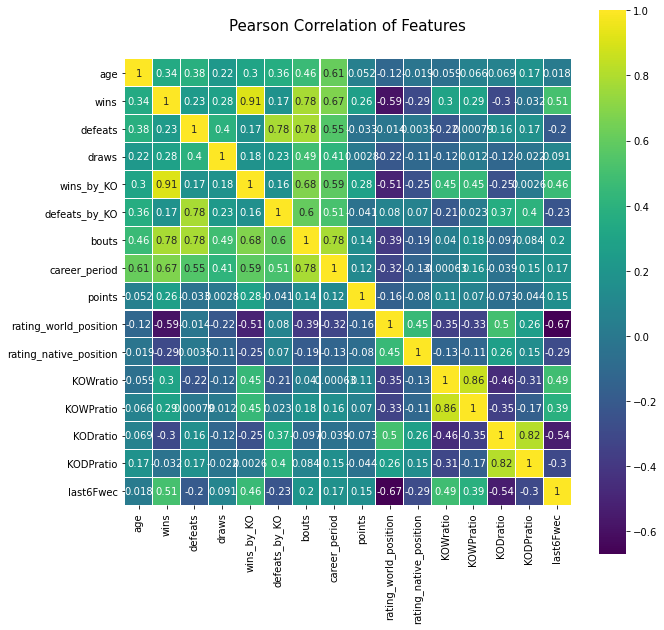

In [252]:
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(braw.drop(columns=['boxerID']).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='viridis', linecolor='white', annot=True)

In [253]:
# tworze prosty model regressi liniowej
# definiuje zmienne
X = np.c_[braw['wins']]
y = np.c_[braw['points']]
# wybieram model
model = sklearn.linear_model.LinearRegression()
# trenuje model
model.fit(X, y)

LinearRegression()

In [254]:
pred= model.predict(X)
pred_reg= pd.concat([pd.DataFrame(pred, columns= ['pred_reg']),
                     pd.DataFrame(y, columns= ['points']),
                     pd.DataFrame(X, columns= ['wins'])],axis=1)

In [255]:
# from sklearn.metrics import confusion_matrix,classification_report
# print(classification_report(y, model.predict(X)))
# print(confusion_matrix(y_train, rfr.predict(X_train)))
# plot_confusion_matrix(rfr, X_train, y_train)
print(model.score(X,y,sample_weight=None)) # returns R^2 of 

0.06990535220665473


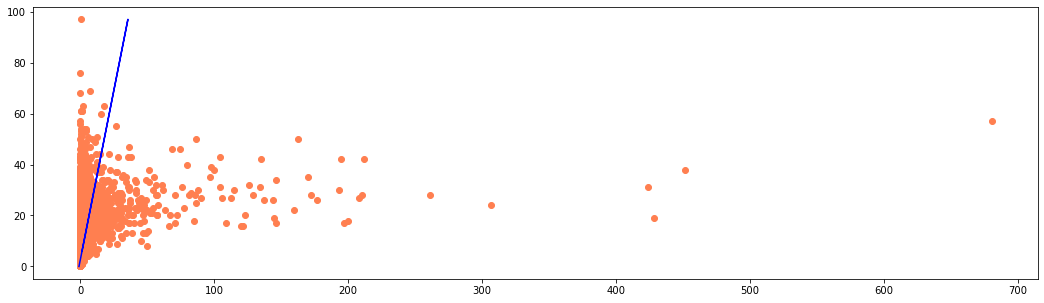

In [256]:
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(pred_reg['points'],pred_reg['wins'], c='coral' )
ax1.plot(pred_reg['pred_reg'],pred_reg['wins'], c='b' )

In [257]:
braw["points"] = braw["points"].replace(-np.inf,0)
print(braw['points'])

37        0.000
379      19.540
2450      0.002
2632      0.097
2714     12.590
          ...  
20042     0.000
20044     0.000
20045     0.000
20048     0.003
20049     0.000
Name: points, Length: 17490, dtype: float64


In [258]:
# Wyznaczam target - wartością ktorą chcę przewidzieć jest rating z kolumny 'points'
X= braw.drop(['points', 'rating_native_position', 'rating_world_position','boxerID', 'debut', 'career edge','boxer'],axis=1)
y= braw['points']
# wprowadzam podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [259]:
# sprawdzam wielkośc zbiorów treningowych
X_train.shape, X_test.shape

((11718, 24), (5772, 24))

In [260]:
# Dane należy skonwertowac do numerycznych
from sklearn.preprocessing import OneHotEncoder 
ohe = OneHotEncoder(handle_unknown='ignore')

# cat_cols=['division','nationality', 'MMA','rating_world_category', 'rating_native_category', 'last1', 'last2',
#           'last3', 'last4', 'last5', 'last6']
ohe.fit(X_train)

X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [261]:
X_train.shape, X_test.shape

((11718, 5356), (5772, 5356))

In [262]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [263]:
print(rfr.predict(X_train))

[0.00553  0.05265  0.3044   ... 1.20781  0.05846  0.015634]


In [264]:
# sprawdzam dokładnosc modelu dla zbioru treningowego
rfr_score= rfr.score(X_train,y_train,sample_weight=None)
print(rfr_score)

0.8554995960474046


In [265]:
# sprawdzam dokładnosc modelu dla zbioru testowego
rfr_predict= rfr.predict(X_test)

In [266]:
rfr_predict.shape, y_test.shape

((5772,), (5772,))

In [267]:
rfr_score= rfr.score(X_test,y_test,sample_weight=None)
print(rfr_score)

-0.15938464335992708


# Mean squared error

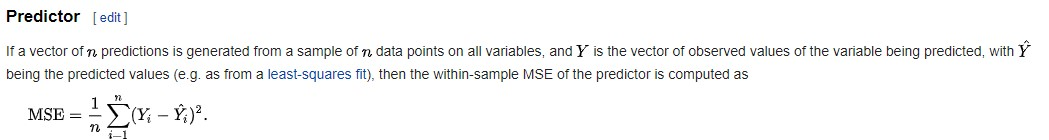

In [268]:
# Błąd średniokwadratowy, średni błąd kwadratowy, MSE dla zbioru treningowego
from sklearn.metrics import mean_squared_error
predicted = rfr.predict(X_train)
mean_squared_error(y_train, predicted)

22.914982922525404

In [269]:
# Błąd średniokwadratowy, średni błąd kwadratowy, MSE dla zbioru testowego
from sklearn.metrics import mean_squared_error
predicted = rfr.predict(X_test)
mean_squared_error(y_test, predicted)

82.95205129380652

# Explained Variance as a Performance Metric
For now, we use explained variance,  EV , as a metric to evaluate the performance of a model:

EV=1−Var(y−y¯)Var(y) 
where  y  is the true price,  y¯  is the estimated price from the model, and  Var(⋅)  is the variance. The  y¯  estimates come from predictions made on the data witheld from training in each round of cross-validation. See: http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

In [270]:
from sklearn.model_selection import cross_val_score
scores_rfr = cross_val_score(rfr,X_train,y_train,cv=10,scoring='explained_variance')

# Est. explained variance: %0.2f (+/- %0.2f)
print(scores_rfr.mean(), scores_rfr.std() * 2)

-0.7442962765957494 2.7898946368408306


 Model nie dziala poprawnie i jest przetrenowany. W celu jego poprawy sprobuję ograniczyc liczbę estymatorów.
 W tym celu sprawdzę czy ograniczenie ilości estymatorów znacząco popawi jakość modelu

In [271]:
# za pomocąpetyli bede uruchamiac model kolejno dla 10,20,50,70,80 drzew. 
# wyniki podsumuję w tabeli

estimators= [10,20,50,70,80]
rows=[]
for i in estimators:
    rfr = RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
    rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
    predicted = rfr.predict(X_test)
    mse_test= mean_squared_error(y_test, predicted)
    rows.append([i, rfr_train_score,rfr_test_score,mse_test])

    
rfr_results= pd.DataFrame(rows, columns= ['estimators','train score', 'test_score','mse_test'] )

In [272]:
rfr_results.sort_values(by="mse_test", ascending=True)

,estimators,train score,test_score,mse_test
4,80,0.856579,-0.113990,79.704120
0,10,0.793406,-0.122532,80.315304
2,50,0.820740,-0.136495,81.314357
1,20,0.841722,-0.138360,81.447758
3,70,0.878935,-0.171842,83.843366


Najmniejszy błąd wychodzi dla 70 drzew , ale to i tak bardzo słaby wynik. 
W nastepnych krokach spróbuję zoptymalizowac ilosc zmiennych wejściowych aby poprawic jakosc predykcji i zapobiec przeuczeniu modelu

Za pomocą dostepnej biblioteki sklearn.feature_selection zamierzam dokonac weryfikacji zmiennych pod katem wpływu na wynik modelu

In [273]:
# przygotowuję dane w celu zaaplikowania do modelu
X= braw.drop(['points', 'rating_native_position', 'rating_world_position','boxerID', 'debut', 'career edge','boxer'],axis=1)
y= braw['points']

In [274]:
X.columns

Index(['age', 'wins', 'defeats', 'draws', 'wins_by_KO', 'defeats_by_KO',
       'division', 'bouts', 'career_period', 'nationality', 'MMA',
       'rating_world_category', 'rating_native_category', 'last1', 'last2',
       'last3', 'last4', 'last5', 'last6', 'KOWratio', 'KOWPratio', 'KODratio',
       'KODPratio', 'last6Fwec'],
      dtype='object')

In [275]:
# zamieniam kolumny na dane kategoryczne na potrzeby algorytmu scoringowego ważność poszczególnych kolumn
braw_c= X.copy()
braw_c['division']= X['division'].astype('category').cat.codes
braw_c['MMA']= X['MMA'].astype('category').cat.codes
braw_c['last1']= X['last1'].astype('category').cat.codes
braw_c['last2']= X['last2'].astype('category').cat.codes
braw_c['last3']= X['last3'].astype('category').cat.codes
braw_c['last4']= X['last4'].astype('category').cat.codes
braw_c['last5']= X['last5'].astype('category').cat.codes
braw_c['last6']= X['last6'].astype('category').cat.codes
braw_c['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
braw_c['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
braw_c['nationality']= X['nationality'].astype('category').cat.codes
braw_c.head()

,age,wins,defeats,draws,wins_by_KO,defeats_by_KO,division,bouts,career_period,nationality,...,last2,last3,last4,last5,last6,KOWratio,KOWPratio,KODratio,KODPratio,last6Fwec
37,44.0,6.0,34.0,1.0,5.0,29.0,15,41.0,8363,134,...,2,2,2,2,1,0.1220,0.8333,0.7073,0.8529,6
379,37.0,34.0,2.0,2.0,25.0,1.0,14,38.0,5818,134,...,4,4,2,1,3,0.6579,0.7353,0.0263,0.5000,20
2450,39.0,1.0,15.0,1.0,1.0,6.0,8,17.0,3186,134,...,2,2,2,2,1,0.0588,1.0000,0.3529,0.4000,6
2632,33.0,14.0,19.0,3.0,8.0,8.0,13,38.0,3030,134,...,2,2,1,4,1,0.2105,0.5714,0.2105,0.4211,11
2714,30.0,23.0,3.0,1.0,12.0,0.0,11,27.0,3009,134,...,4,2,4,2,1,0.4444,0.5217,0.0000,0.0000,15


In [276]:
# feature selection library in scikit-learn
import sklearn.feature_selection as fs 
mir_result = fs.mutual_info_regression(braw_c, y)

In [277]:
included_features = X.columns
feature_scores = []
for i in np.arange(len(included_features)):
    feature_scores.append([included_features[i],mir_result[i]])
    
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

[['wins' '0.6327125728562191']
 ['last6Fwec' '0.4930182965179224']
 ['KODratio' '0.4080865032764516']
 ['wins_by_KO' '0.3978138111663432']
 ['KOWPratio' '0.3769094190542699']
 ['KOWratio' '0.35516398570192464']
 ['bouts' '0.32467642954851783']
 ['last2' '0.2851092589641673']
 ['last1' '0.275244849700242']
 ['last3' '0.27229690241605997']
 ['last4' '0.2529010736372528']
 ['last5' '0.20827369058589928']
 ['career_period' '0.19254016127789875']
 ['KODPratio' '0.1324665395687834']
 ['last6' '0.11729827563920248']
 ['defeats' '0.10885950241780051']
 ['nationality' '0.09337921060582932']
 ['defeats_by_KO' '0.07702160117591728']
 ['draws' '0.06717509041252878']
 ['rating_native_category' '0.0580807715654581']
 ['division' '0.049705782888277206']
 ['rating_world_category' '0.04356373762279109']
 ['age' '0.03723366687605445']
 ['MMA' '0.0011880428551651612']]


Udało sie otrzymać scoring zmiennych. W celu wizualizacji wyniku tworzę wykres:

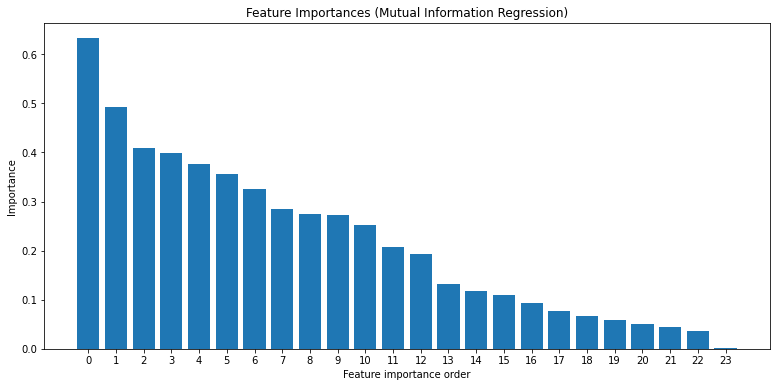

In [278]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features))
plt.bar(ind,[float(i) for i in np.array(sorted_scores)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
plt.xlabel('Feature importance order')
# plt.grid()
plt.show()

Przyjmuję strategię aby sprawdzić performance modelu w zależnosci od ilości zaaplikowanych zmiennych oraz ilości drzew.

Powtarzam procedure trenowania modelu zgodnie z przyjętą strategią

In [279]:
# przygotowuję listę zmiennych tak aby aplikowac co 4 zmienne 
sorted_scores_df= pd.DataFrame(sorted_scores, columns=['sorted_column','importance_score'])
sorted_scores_list= sorted_scores_df['sorted_column'].tolist()
sorted_scores_list[:4]

['wins', 'last6Fwec', 'KODratio', 'wins_by_KO']

In [ ]:
#    Model nie dziala poprawnie i jest przetrenowany 
# sprawdze z jaka iloscia estymatorów oraz jaka iloscia X model bedzie najbardziej efektywny
estimators= [10,20,50,70,80,100]
nfeatures = list(range(4,len(sorted_scores_list)+1, 4))
rows1=[]
for j in nfeatures:
    X= braw.loc[:,(sorted_scores_list[:j])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    # normalizacja zmiennych za pomocą OneHotEncoder
    ohe.fit(X_train)
    X_train = ohe.transform(X_train)
    X_test = ohe.transform(X_test)
    for i in estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train, y_train)
        rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
        rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
        predicted = rfr.predict(X_test)
        mse_test= mean_squared_error(y_test, predicted)
        rows1.append([i,j, rfr_train_score,rfr_test_score,mse_test])

    
rfr_results1= pd.DataFrame(rows1, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results1.sort_values(by="mse_test", ascending=True)

C:\Users\Karol\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Karol\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Karol\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Karol\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Karol\anaconda3\lib\site-packages\sklearn\u

In [ ]:
rfr_results1= pd.DataFrame(rows1, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results1.sort_values(by="mse_test", ascending=True)

In [ ]:
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results2['estimators'],rfr_results2['test_score'], c='coral' )
ax1.plot(rfr_results2['estimators'],rfr_results2['test_score'], c='coral' )
ax1.scatter(rfr_results2['nfeatures'],rfr_results2['test_score'], c='b' )
ax1.plot(rfr_results2['nfeatures'],rfr_results2['test_score'], c='b' )
plt.title("Prediction score on the TEST sample vs. estimators and features ount")
plt.xlabel("estimators and features count")
plt.ylabel("Prediction score on the TEST sample")

In [ ]:
# wyrkes obrazujący jak zmienia sie dokładnośc predykcji w zależności od ilości drzew
rfr_results1_f2 = rfr_results1[rfr_results1['nfeatures'].isin(['2'])]
rfr_results1_f4 = rfr_results1[rfr_results1['nfeatures'].isin(['4'])]
rfr_results1_f6 = rfr_results1[rfr_results1['nfeatures'].isin(['6'])]
rfr_results1_f8 = rfr_results1[rfr_results1['nfeatures'].isin(['8'])]
rfr_results1_f10 = rfr_results1[rfr_results1['nfeatures'].isin(['10'])]

fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results1_f2['estimators'],rfr_results1_f2['test_score'], c='b' )
ax1.plot(rfr_results1_f2['estimators'],rfr_results1_f2['test_score'], c='b' )
ax1.scatter(rfr_results1_f4['estimators'],rfr_results1_f4['test_score'], c='g' )
ax1.plot(rfr_results1_f4['estimators'],rfr_results1_f4['test_score'], c='g' )
ax1.scatter(rfr_results1_f6['estimators'],rfr_results1_f6['test_score'], c='c' )
ax1.plot(rfr_results1_f6['estimators'],rfr_results1_f6['test_score'], c='c' )
ax1.scatter(rfr_results1_f8['estimators'],rfr_results1_f8['test_score'], c='k' )
ax1.plot(rfr_results1_f8['estimators'],rfr_results1_f8['test_score'], c='k' )
ax1.scatter(rfr_results1_f10['estimators'],rfr_results1_f10['test_score'], c='slategray' )
ax1.plot(rfr_results1_f10['estimators'],rfr_results1_f10['test_score'], c='slategray' )

plt.title("Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("estimators count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

In [ ]:
# wyrkes obrazujący jak zmienia sie dokładnośc predykcji w zależności od zastosowanych kolumn
rfr_results1_t100 = rfr_results1[rfr_results1['estimators'].isin(['100'])]
rfr_results1_t80 = rfr_results1[rfr_results1['estimators'].isin(['80'])]
rfr_results1_t70 = rfr_results1[rfr_results1['estimators'].isin(['70'])]
rfr_results1_t50 = rfr_results1[rfr_results1['estimators'].isin(['50'])]
rfr_results1_t20 = rfr_results1[rfr_results1['estimators'].isin(['20'])]
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results1_t100['nfeatures'],rfr_results1_t100['test_score'], c='b' )
ax1.plot(rfr_results1_t100['nfeatures'],rfr_results1_t100['test_score'], c='b' )
ax1.scatter(rfr_results1_t80['nfeatures'],rfr_results1_t80['test_score'], c='g' )
ax1.plot(rfr_results1_t80['nfeatures'],rfr_results1_t80['test_score'], c='g' )
ax1.scatter(rfr_results1_t70['nfeatures'],rfr_results1_t70['test_score'], c='c' )
ax1.plot(rfr_results1_t70['nfeatures'],rfr_results1_t70['test_score'], c='c' )
ax1.scatter(rfr_results1_t50['nfeatures'],rfr_results1_t50['test_score'], c='k' )
ax1.plot(rfr_results1_t50['nfeatures'],rfr_results1_t50['test_score'], c='k' )
ax1.scatter(rfr_results1_t20['nfeatures'],rfr_results1_t20['test_score'], c='slategray' )
ax1.plot(rfr_results1_t20['nfeatures'],rfr_results1_t20['test_score'], c='slategray' )
ax1.axes.set_xticks(ind)
xlim=(2,23)
plt.title("Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

# PCA

Sprawdze czy osiągnę lepszy wynik stosując PCA 


In [ ]:
# przekształcam kolumnę z datą tak aby była interpretowalna dla standat scaller
braw['debut'] = pd.to_datetime(braw['debut'])
braw['debut']= braw['debut'].map(dt.datetime.toordinal)

In [ ]:
X= braw.loc[:,(sorted_scores_list[:])]
y= braw['points']

In [ ]:
braw.loc[:,(sorted_scores_list[:24])]

In [ ]:
braw_c= X.copy()
braw_c['division']= X['division'].astype('category').cat.codes
braw_c['MMA']= X['MMA'].astype('category').cat.codes
braw_c['last1']= X['last1'].astype('category').cat.codes
braw_c['last2']= X['last2'].astype('category').cat.codes
braw_c['last3']= X['last3'].astype('category').cat.codes
braw_c['last4']= X['last4'].astype('category').cat.codes
braw_c['last5']= X['last5'].astype('category').cat.codes
braw_c['last6']= X['last6'].astype('category').cat.codes
braw_c['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
braw_c['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
braw_c['nationality']= X['nationality'].astype('category').cat.codes
X= braw_c.copy()

In [ ]:
# wprowadzam podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
# normalizacja zmiennych za pomocą OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder 
# ohe = OneHotEncoder(handle_unknown='ignore')
# ohe.fit(X_train)
# X_train = ohe.transform(X_train)
# X_test = ohe.transform(X_test)

In [ ]:
# tym razem do normalizacji posłużę sie metodą skalowania danych wykorzystującą bibliotekę StandardScaler
from sklearn.preprocessing import StandardScaler
X_train.astype('float')
# X_train.dropna(inplace=True)
X_train_s = StandardScaler(with_mean=False).fit_transform(X_train)
X_test_s = StandardScaler(with_mean=False).fit_transform(X_test)

In [ ]:
X_train_s.shape

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.fit_transform(X_test_s)

In [ ]:
np.min(X_train_pca)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,6))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], s=20, c = y_train, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
plt.clim(0,10)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)

Sprawdzam jak model Randon Forest Regeressor zachowa się po normalizacji metodą PCA

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train_pca, y_train)
rfr_train_score = rfr.score(X_train_pca,y_train,sample_weight=None)
rfr_test_score = rfr.score(X_test_pca,y_test,sample_weight=None)
predicted = rfr.predict(X_test_pca)
mse_test= mean_squared_error(y_test, predicted)


In [ ]:
print("rfr_train_score: ",rfr_train_score,"; rfr_test_score: ", rfr_test_score, "; mse_test: ", mse_test)

Jak widać model dalej jest przeuczony. Podejmę próbę zwiększenia estymatorów w PCA

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.fit_transform(X_test_s)

In [ ]:
list(range(2,23))

In [ ]:
estimators= [10,20,50,70,80,100] # ilosc drzew w random forest
nfeatures = list(range(2,23)) # ilosc estymatorów PCA
rows3=[]
for j in nfeatures:
    pca = PCA(n_components=j)
    X_train_pca = pca.fit_transform(X_train_s)
    X_test_pca = pca.fit_transform(X_test_s)
    for i in estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train_pca, y_train)
        rfr_train_score = rfr.score(X_train_pca,y_train,sample_weight=None)
        rfr_test_score = rfr.score(X_test_pca,y_test,sample_weight=None)
        predicted = rfr.predict(X_test_pca)
        mse_test= mean_squared_error(y_test, predicted)
        rows3.append([i,j, rfr_train_score,rfr_test_score,mse_test])

    
rfr_results2= pd.DataFrame(rows3, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results2.sort_values(by="mse_test", ascending=True)

In [ ]:
rfr_results3 = rfr_results2
rfr_results3_f2 = rfr_results3[rfr_results3['nfeatures'].isin(['2'])]
rfr_results3_f4 = rfr_results3[rfr_results3['nfeatures'].isin(['4'])]
rfr_results3_f6 = rfr_results3[rfr_results3['nfeatures'].isin(['6'])]
rfr_results3_f8 = rfr_results3[rfr_results3['nfeatures'].isin(['8'])]
rfr_results3_f10 = rfr_results3[rfr_results3['nfeatures'].isin(['10'])]

fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results3_f2['estimators'],rfr_results3_f2['test_score'], c='b' )
ax1.plot(rfr_results3_f2['estimators'],rfr_results3_f2['test_score'], c='b' )
ax1.scatter(rfr_results3_f4['estimators'],rfr_results3_f4['test_score'], c='g' )
ax1.plot(rfr_results3_f4['estimators'],rfr_results3_f4['test_score'], c='g' )
ax1.scatter(rfr_results3_f6['estimators'],rfr_results3_f6['test_score'], c='c' )
ax1.plot(rfr_results3_f6['estimators'],rfr_results3_f6['test_score'], c='c' )
ax1.scatter(rfr_results3_f8['estimators'],rfr_results3_f8['test_score'], c='k' )
ax1.plot(rfr_results3_f8['estimators'],rfr_results3_f8['test_score'], c='k' )
ax1.scatter(rfr_results3_f10['estimators'],rfr_results3_f10['test_score'], c='slategray' )
ax1.plot(rfr_results3_f10['estimators'],rfr_results3_f10['test_score'], c='slategray' )

plt.title("Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("estimators count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

In [ ]:
rfr_results3 = rfr_results2
rfr_results3_t100 = rfr_results3[rfr_results3['estimators'].isin(['100'])]
rfr_results3_t80 = rfr_results3[rfr_results3['estimators'].isin(['80'])]
rfr_results3_t70 = rfr_results3[rfr_results3['estimators'].isin(['70'])]
rfr_results3_t50 = rfr_results3[rfr_results3['estimators'].isin(['50'])]
rfr_results3_t20 = rfr_results3[rfr_results3['estimators'].isin(['20'])]
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results3_t100['nfeatures'],rfr_results3_t100['test_score'], c='b' )
ax1.plot(rfr_results3_t100['nfeatures'],rfr_results3_t100['test_score'], c='b' )
ax1.scatter(rfr_results3_t80['nfeatures'],rfr_results3_t80['test_score'], c='g' )
ax1.plot(rfr_results3_t80['nfeatures'],rfr_results3_t80['test_score'], c='g' )
ax1.scatter(rfr_results3_t70['nfeatures'],rfr_results3_t70['test_score'], c='c' )
ax1.plot(rfr_results3_t70['nfeatures'],rfr_results3_t70['test_score'], c='c' )
ax1.scatter(rfr_results3_t50['nfeatures'],rfr_results3_t50['test_score'], c='k' )
ax1.plot(rfr_results3_t50['nfeatures'],rfr_results3_t50['test_score'], c='k' )
ax1.scatter(rfr_results3_t20['nfeatures'],rfr_results3_t20['test_score'], c='slategray' )
ax1.plot(rfr_results3_t20['nfeatures'],rfr_results3_t20['test_score'], c='slategray' )
ax1.axes.set_xticks(ind)
xlim=(2,23)
plt.title("Prediction score on the TEST sample vs. estimators and features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

# XGBoost

na koniec sprawdze jak z moimi danymi poradzi sobie XGBoost 

In [ ]:
X= braw.loc[:,(sorted_scores_list[:])]
y= braw['points']

# zamieniam kolumny na dane kategoryczne na potrzeby algorytmu scoringowego ważność poszczególnych kolumn

X['division']= X['division'].astype('category').cat.codes
X['MMA']= X['MMA'].astype('category').cat.codes
X['last1']= X['last1'].astype('category').cat.codes
X['last2']= X['last2'].astype('category').cat.codes
X['last3']= X['last3'].astype('category').cat.codes
X['last4']= X['last4'].astype('category').cat.codes
X['last5']= X['last5'].astype('category').cat.codes
X['last6']= X['last6'].astype('category').cat.codes
X['rating_world_category']= X['rating_world_category'].astype('category').cat.codes
X['rating_native_category']= X['rating_native_category'].astype('category').cat.codes
X['nationality']= X['nationality'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
predicted = rfr.predict(X_test_pca)
mse_test= mean_squared_error(y_test, predicted)
print("rfr_train_score: ",rfr_train_score,"; rfr_test_score: ", rfr_test_score, "; mse_test: ", mse_test)

In [ ]:
# sprawdzam czy zastosowanie OneHotEncoder pomoże
X= braw.loc[:,(sorted_scores_list[:])]
y= braw['points'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

xgb_train_score = model_xgb.score(X_train,y_train,sample_weight=None)
xgb_test_score = model_xgb.score(X_test,y_test,sample_weight=None)
predicted = rfr.predict(X_test_pca)
mse_test= mean_squared_error(y_test, predicted)
print("rfr_train_score: ",rfr_train_score,"; rfr_test_score: ", rfr_test_score, "; mse_test: ", mse_test)

In [ ]:
#    Model nie dziala poprawnie i jest przetrenowany 
# sprawdze z jaka iloscia X model bedzie najbardziej efektywny
# estimators= [10,20,50,70,80,100]
nfeatures = list(range(4,len(sorted_scores_list)+1, 4))
rows4=[]
for j in nfeatures:
    X= braw.loc[:,(sorted_scores_list[:j])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    # normalizacja zmiennych za pomocą OneHotEncoder
    ohe.fit(X_train)
    X_train = ohe.transform(X_train)
    X_test = ohe.transform(X_test)
    rfr = RandomForestRegressor(n_estimators=i)
    rfr.fit(X_train, y_train)
    rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
    rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
    predicted = rfr.predict(X_test)
    mse_test= mean_squared_error(y_test, predicted)
    rows4.append([j, rfr_train_score,rfr_test_score,mse_test])

    
rfr_results4= pd.DataFrame(rows4, columns= ['nfeatures','train score', 'test_score','mse_test'] )

In [ ]:
rfr_results4.sort_values(by="mse_test", ascending=True)

In [ ]:
fig,ax1 = plt.subplots(figsize=(18, 5))
ax1.scatter(rfr_results4['nfeatures'],rfr_results4['test_score'], c='b' )
ax1.plot(rfr_results4['nfeatures'],rfr_results4['test_score'], c='b' )
# ax1.scatter(rfr_results3_t80['nfeatures'],rfr_results3_t80['test_score'], c='g' )
# ax1.plot(rfr_results3_t80['nfeatures'],rfr_results3_t80['test_score'], c='g' )
# ax1.scatter(rfr_results3_t70['nfeatures'],rfr_results3_t70['test_score'], c='c' )
# ax1.plot(rfr_results3_t70['nfeatures'],rfr_results3_t70['test_score'], c='c' )
# ax1.scatter(rfr_results3_t50['nfeatures'],rfr_results3_t50['test_score'], c='k' )
# ax1.plot(rfr_results3_t50['nfeatures'],rfr_results3_t50['test_score'], c='k' )
# ax1.scatter(rfr_results3_t20['nfeatures'],rfr_results3_t20['test_score'], c='slategray' )
# ax1.plot(rfr_results3_t20['nfeatures'],rfr_results3_t20['test_score'], c='slategray' )
ax1.axes.set_xticks(ind)
# xlim=(2,24)
plt.title("Prediction score on the TEST sample vs. features count", size=20)
plt.xlabel("features count", size=15)
plt.ylabel("Prediction score on the TEST sample", size=15)

In [ ]:
#    Model nie dziala poprawnie i jest przetrenowany 
# sprawdze z jaka iloscia estymatorów oraz jaka iloscia X model bedzie najbardziej efektywny
estimators= [10,20,50,70,80,100]
nfeatures = list(range(4,len(sorted_scores_list)+1, 4))
rows5=[]
for j in nfeatures:
    X= braw.loc[:,(sorted_scores_list[:j])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    # normalizacja zmiennych za pomocą OneHotEncoder
    ohe.fit(X_train)
    X_train = ohe.transform(X_train)
    X_test = ohe.transform(X_test)
    for i in estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train, y_train)
        rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
        rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
        predicted = rfr.predict(X_test)
        mse_test= mean_squared_error(y_test, predicted)
        rows5.append([i,j, rfr_train_score,rfr_test_score,mse_test])

In [ ]:
rfr_results5= pd.DataFrame(rows5, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results5.sort_values(by="mse_test", ascending=True)

In [ ]:
adjusted_features = ['wins','defeats','draws','age','career_period','wins_by_KO','defeats_by_KO','last6Fwec','division','bouts']
list(range(2,len(adjusted_features)+1, 2))


In [ ]:
braw.loc[:,(adjusted_features[:10])].head()

In [ ]:
#    Model nie dziala poprawnie i jest przetrenowany 
# sprawdze z jaka iloscia estymatorów oraz jaka iloscia X model bedzie najbardziej efektywny
estimators= [10,20,50,70,80,100]
nfeatures = list(range(2,len(adjusted_features)+1, 2))
rows7=[]
for j in nfeatures:
    X= braw.loc[:,(adjusted_features[:j])]
    y= braw['points']
    # wprowadzam podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    # normalizacja zmiennych za pomocą OneHotEncoder
    ohe.fit(X_train)
    X_train = ohe.transform(X_train)
    X_test = ohe.transform(X_test)
    for i in estimators:
        rfr = RandomForestRegressor(n_estimators=i)
        rfr.fit(X_train, y_train)
        rfr_train_score = rfr.score(X_train,y_train,sample_weight=None)
        rfr_test_score = rfr.score(X_test,y_test,sample_weight=None)
        predicted = rfr.predict(X_test)
        mse_test= mean_squared_error(y_test, predicted)
        rows7.append([i,j, rfr_train_score,rfr_test_score,mse_test])


In [ ]:
    
rfr_results7= pd.DataFrame(rows7, columns= ['estimators','nfeatures','train score', 'test_score','mse_test'] )
rfr_results7.sort_values(by="mse_test", ascending=True)